# EJERCICIO 3 - SPAM CLASSIFICATION

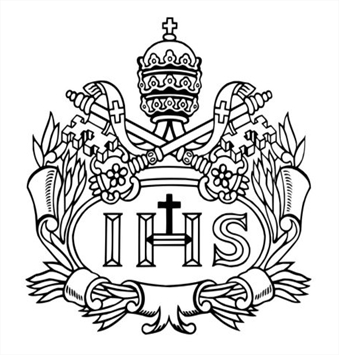

#INTEGRANTES DEL GRUPO

1. SONIA RAMÍREZ
2. MILI GALINDO
3. ANGUIE GARCÍA
4. LOURDES RODIL

# Exercise 3
## Spam Classification
### Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link](http://www.grumbletext.co.uk/).
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/).
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link](http://www.esp.uem.es/jmgomez/smsspamcorpus/). This corpus has been used in the following academic researches:

Acknowledgements
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

In [41]:
!pip install wget

In [42]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve

import gensim
from gensim.models import Word2Vec
import warnings


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2024-03-23 18:45:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip.2’

smsspamcollection.z     [    <=>             ] 198.65K   293KB/s    in 0.7s    

2024-03-23 18:45:24 (293 KB/s) - ‘smsspamcollection.zip.2’ saved [203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [44]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [45]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [46]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [47]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

Preprocess the text data by removing stop words, converting all text to lowercase, and removing punctuation using NLTK package.


In [48]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

Train a Word2Vec model on the preprocessed training data using Gensim package.

In [49]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)

Convert the preprocessed text data to a vector representation using the Word2Vec model.

In [50]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

Train a classification model such as logistic regression, random forests, or support vector machines using the vectorised training data and the sentiment labels.

In [51]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

Evaluate the performance of the classification model on the testing set with the accuracy, precision, recall and F1 score.

In [52]:
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.8660287081339713
AUC: 0.5


# Excercise 3.1

Remove stopwords, then predict target using CountVectorizer.

use Random Forest classifier

In [53]:
# 1. Cargue de Librerías

import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve

import gensim
from gensim.models import Word2Vec
import warnings


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df1 = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2024-03-23 18:47:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip.3’

smsspamcollection.z     [        <=>         ] 198.65K   103KB/s    in 1.9s    

2024-03-23 18:47:28 (103 KB/s) - ‘smsspamcollection.zip.3’ saved [203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [55]:
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [56]:
# 2. Identificamos en el dataset la variable objetivo

X = df1['text']
y = df1['target'].map({'ham':0, 'spam':1})

In [85]:
# 2.1. Análisis de estructura del texto

df1['num_characters'] = df1['text'].apply(len)
df1['num_words'] = df1['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df1['num_sentence'] = df1['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [86]:
df1[['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,5572.000000,5572.000000,5572.000000
mean,80.489950,18.842426,2.006102
std,59.942907,13.851947,1.539977
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,62.000000,15.000000,2.000000
75%,122.000000,27.000000,3.000000
max,910.000000,220.000000,38.000000


In [88]:
# 2.2. Resumen de estadísticas  para mensajes legítimos
df1[df1['target'] == 'ham'][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,4825.000000,4825.000000,4825.000000
mean,71.482487,17.425699,1.846010
std,58.440652,14.118631,1.475377
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,93.000000,23.000000,2.000000
max,910.000000,220.000000,38.000000


Se observa que el número de palabras en los mensajes legítimos es de 4.825 palabras.

In [89]:
# 2.3. Resumen de estadísticas para mensajes Spam
df1[df1['target'] == 'spam'][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,747.000000,747.000000,747.000000
mean,138.670683,27.993307,3.040161
std,28.873603,6.860440,1.548499
min,13.000000,2.000000,1.000000
25%,133.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


Se observa que el número de palabras en los mensajes spam es de 747 palabras.

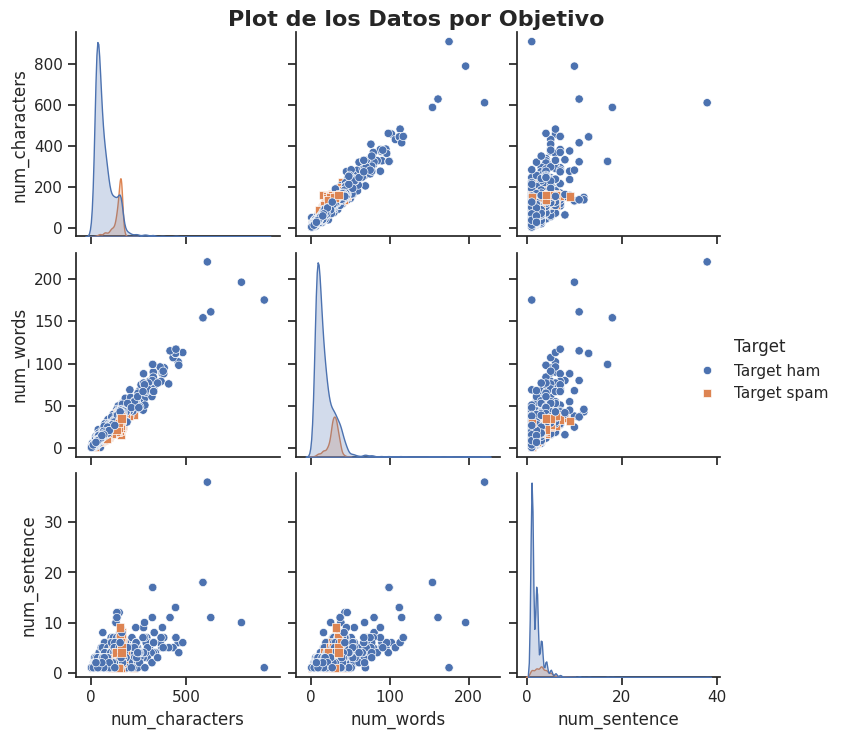

In [92]:
# 2.4 Visualización del comportamiento de los datos

import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot with custom styling
sns.set(style='ticks', color_codes=True)
g = sns.pairplot(df1, hue='target', diag_kind='kde', markers=["o", "s"])

# Set a title for the pairplot
g.fig.suptitle("Plot de los Datos por Objetivo", fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.95)  # Adjust the position of the title

# Customize the legend
g._legend.set_title('Target')
for t, l in zip(g._legend.texts, ["Target ham", "Target spam"]):
    t.set_text(l)

# Show the pairplot
plt.show()

In [94]:
# 2.5 Análisis de palabras comunes en mensajes spam

# Importing the Porter Stemmer for text stemming
from nltk.stem.porter import PorterStemmer

# Importing the string module for handling special characters
import string

# Creating an instance of the Porter Stemmer
ps = PorterStemmer()

# Lowercase transformation and text preprocessing function
def transform_text(text):
    # Transform the text to lowercase
    text = text.lower()

    # Tokenization using NLTK
    text = nltk.word_tokenize(text)

    # Removing special characters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    # Removing stop words and punctuation
    text = y[:]
    y.clear()

    # Loop through the tokens and remove stopwords and punctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    # Stemming using Porter Stemmer
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))

    # Join the processed tokens back into a single string
    return " ".join(y)

In [95]:
#Creamos un nuevo campo en el dataframe en el cual el texto se incluye con stopwords
df['transformed_text'] = df1['text'].apply(transform_text)

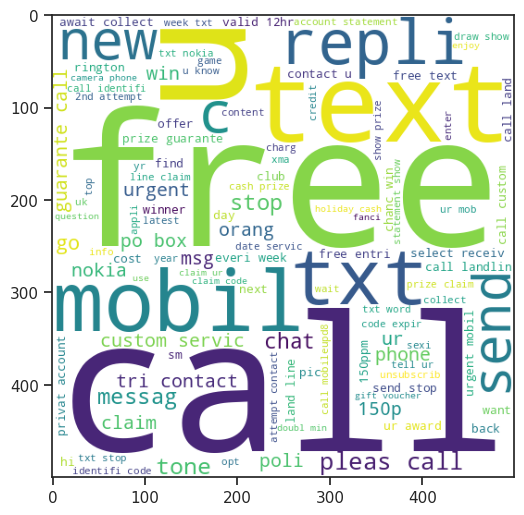

In [97]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(df[df['target'] == 'spam']['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

En el análisis de palabras comunes se observa que la más común es "free" y "call". Llama la atención que una palabra común es 'txt', el cual puede considerarse un stopword dada la naturaleza del database compuesta por mensajes de texto, por lo que sería necesario procesarla para evaluarla correctamente.

In [57]:
# 3. Separamos los datos de entrenamiento (70%) de los de prueba (30%)
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, stratify = df1['target'], test_size = 0.3, random_state = 10)

In [58]:
# 4. Removemos Stopwords
stop_words = set(stopwords.words('english'))
def remove_sw (text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_Train = X_Train.apply(remove_sw)
X_Test = X_Test.apply(remove_sw)


In [59]:
# 5. Predecir Variable objetivo usando CountVectorizer

# 5.1. Inicializar el CountVectorizer con un rango de n-gramas de 1 a 2 (unigramas y bigramas) y un máximo de características a extraer de 1000

vect = CountVectorizer(ngram_range=(1, 2), max_features=1000)

# 5.2 Ajustar el CountVectorizer al database y transformar los documentos en una matriz de recuento de términos
X_Train_mx_rcto = vect.fit_transform(X_Train)
X_Test_mx_rcto = vect.fit_transform(X_Test)

# 5.3 Inicializar el clasificador RandomForest con 10 árboles y una profundidad de 5 niveles
clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)

# 5.4 Entrenar el clasificador
clf.fit(X_Train_mx_rcto, y_Train)

# 5.5 Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_Test_mx_rcto)



In [60]:
# 6. Calcular la precisión del clasificador
accuracy = accuracy_score(y_Test, y_pred)
fpr, tpr, thresholds = roc_curve(y_Test, y_pred)

print("Precisión del clasificador RandomForest usando CountVectorizer:", accuracy)
print('AUC usando CountVectorizer:', auc(fpr, tpr))

Precisión del clasificador RandomForest usando CountVectorizer: 0.8690191387559809
AUC usando CountVectorizer: 0.5111607142857143


Se observa que en comparación con la predicción realizada con una regresión logística, con una técnica de RandomForest con 10 árboles y una profundidad de 5 niveles, el accuracy sube a 0.8690 y el área bajo la curva aumenta ligeramente a 0.51.

# Excercise 3.2

Predict target using TdidfVectorizer.

use Random Forest classifier

In [61]:
# 1. Cargue de Librerías

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [62]:
# 2. Predecir la variable objetivo usando TdidfVectorizer

# 2.1 Inicializamos el TfidfVectorizer

vect1 = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)

# 2.2 Ajustar el TfidfVectorizer al database y transformar los documentos en una matriz de recuento de términos
X_Train_mx_rcto1 = vect1.fit_transform(X_Train)
X_Test_mx_rcto1 = vect1.fit_transform(X_Test)

# 2.3 Inicializar el clasificador RandomForest con 10 árboles y una profundidad de 5 niveles
clf1 = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)

# 2.4 Entrenar el clasificador
clf1.fit(X_Train_mx_rcto1, y_Train)

# 2.5 Realizar predicciones en el conjunto de prueba
y_pred1 = clf1.predict(X_Test_mx_rcto1)

In [63]:
# 3. Calcular la precisión del clasificador
accuracy = accuracy_score(y_Test, y_pred1)
fpr, tpr, thresholds = roc_curve(y_Test, y_pred1)

print("Precisión del clasificador RandomForest usando TfidfVectorizer:", accuracy)
print('AUC usando TfidfVectorizer:', auc(fpr, tpr))

Precisión del clasificador RandomForest usando TfidfVectorizer: 0.8672248803827751
AUC usando TfidfVectorizer: 0.5044642857142857


Se observa que usando TfidVectorizer, el accuracy baja levemente a 0.8672 y el área bajo la curva baja ligeramente a 0.504, manteniendo los mismos parámetros en el RandomForest.

# Excercise 3.3

Predict target using CountVectorizer or TfideVectorizer.

choose any classification model and justify why

In [64]:
# 1. Cargue de Librerías
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC


Dado que los resultados fueron un poco mejores con CountVectorizer en términos del accuracy, realizaremos la predicción usando éste para la matriz de recuento de términos.

In [102]:
# 2. Predecir Variable objetivo usando CountVectorizer
# 2.1 Inicializar el CountVectorizer con un rango de n-gramas de 1 a 2 (unigramas y bigramas) y un máximo de características a extraer de 1000

vect = CountVectorizer(ngram_range=(1, 2), max_features=2000)

# 2.2 Ajustar el CountVectorizer al database y transformar los documentos en una matriz de recuento de términos
X_Train_mx_rcto2 = vect.fit_transform(X_Train)
X_Test_mx_rcto2 = vect.fit_transform(X_Test)

# 2.3 Inicializar el clasificador con un modelo svm de clasificación:
clf2 = SVC(kernel= "sigmoid", gamma  = 1.0)

# 2.4 Entrenar el clasificador
clf2.fit(X_Train_mx_rcto2, y_Train)

# 2.5 Realizar predicciones en el conjunto de prueba
y_pred2 = clf2.predict(X_Test_mx_rcto2)

In [66]:
# 3. Calcular la precisión del clasificador
accuracy = accuracy_score(y_Test, y_pred2)
fpr, tpr, thresholds = roc_curve(y_Test, y_pred2)

print("Precisión del clasificador SVM usando CountVectorizer:", accuracy)
print('AUC usando SVM con CountVectorizer:', auc(fpr, tpr))

Precisión del clasificador SVM usando CountVectorizer: 0.8767942583732058
AUC usando SVM con CountVectorizer: 0.6137652920284135


Escogimos un Support Vector Machine (SVM) para clasificación con un kernel sigmoide, ya que los datos de mensajes pueden tener una estructura no lineal y compleja. En tales casos, los modelos lineales pueden no ser capaces de capturar adecuadamente la relación entre las características y la variable objetivo. El uso de un kernel no lineal como el sigmoide en un modelo SVC permite capturar relaciones no lineales entre las características y la etiqueta de spam.

A partir de los resultados observados, vemos que con este último modelo tiene un mejor desempeño con un accuracy de 0.87 y un AUC de 0.61.

# Excercise 3.4

Increase and decrece the parameters values vector_size, window and negative then predict the target.

Plot the different values of the parameters with the performance of the model.

Use a Random Forest classifier and classification model of your choice and justify why.

In [114]:
# 1.Importar librerías

import gensim
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [68]:
# 2. Recordemos nuestro dataset

X = df1['text']
y = df1['target'].map({'ham':0, 'spam':1})

In [69]:
X_Train.head()

329                                cool text youre parked
1392                        haha kidding papa needs drugs
3215    babe got enough money pick bread milk ill give...
1969             2 laptop noe infra slow lar wan fast one
5100                               aight call youre close
Name: text, dtype: object

In [70]:
X_Test.head()

4034             taking italian food pretty dress panties
967                        sure night menu know noon menu
3306    ee msg na poortiyagi odalebeku hanumanji 7 nam...
5238                                 yeah still give ride
2235    whats room number wan na make sure im knocking...
Name: text, dtype: object

parameter variation: `vector_size`

In [81]:
# 3. Variación del parámetro vector_size

vector_size_rta = pd.DataFrame(columns = ['modelo', 'vector_size', 'Accuracy', 'AUC'])
modelo_rf = RandomForestClassifier()
svc = SVC(kernel= "sigmoid", gamma  = 1.0)
vectores_palabras = []

Además del Random Forest usaremos un modelo SVM para clasificación, ya que estos modelos son conocidos por su capacidad para generalizar bien en conjuntos de datos de alta dimensionalidad, incluso cuando la relación entre las características y la clase objetivo es compleja. Esto los hace adecuados para problemas de clasificación de texto como la detección de spam, donde las relaciones pueden ser difíciles de capturar con modelos más simples.

In [82]:
# 4. Creamos array de parámetros para iterar el vector size

j=0

for modelo_final in ['modelo_rf', 'svc']:
  print(modelo_final)
  for i in range (10,210,10):
    print (i)

    model2_w2v = Word2Vec(X_Train, vector_size=i, window=5, negative=20, min_count=1, workers=4)

    words = set(model2_w2v.wv.index_to_key)
    X_Train_2 = np.array([np.array([model2_w2v.wv[i] for i in ls if i in words])
                            for ls in X_train])
    X_Test_2 = np.array([np.array([model2_w2v.wv[i] for i in ls if i in words])
                            for ls in X_test])

    X_train_avg = []
    for v in X_Train_2:
            X_train_avg.append(v.mean(axis=0))

    X_test_avg = []
    for v in X_Test_2:
            X_test_avg.append(v.mean(axis=0))

    if modelo_final == 'modelo_rf':
      modelo_rf = RandomForestClassifier()
      modelo_rf.fit(X_train, y_train)
      y_pred3 = modelo_rf.predict(X_test)
      fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

      vector_size_rta.at[j, 'modelo'] = 'random_forest'
      vector_size_rta.at[j, 'vector_size'] = i
      vector_size_rta.at[j, 'Accuracy'] = accuracy_score(y_test, y_pred3)
      vector_size_rta.at[j, 'AUC'] = auc(fpr, tpr)

      j = j+1

    if modelo_final == 'svc':
      modelo_rf = SVC()
      modelo_rf.fit(X_train, y_train)
      y_pred3 = modelo_rf.predict(X_test)
      fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

      vector_size_rta.at[j, 'modelo'] = 'svm'
      vector_size_rta.at[j, 'vector_size'] = i
      vector_size_rta.at[j, 'Accuracy'] = accuracy_score(y_test, y_pred3)
      vector_size_rta.at[j, 'AUC'] = auc(fpr, tpr)

      j = j+1

modelo_rf
10


20


30


40


50


60


70


80


90


100


110


120


130


140


150


160


170


180


190


200


svc
10


20


30


40


50


60


70


80


90


100


110


120


130


140


150


160


170


180


190


200


In [83]:
#Visualizamos los resultados de los modelos
vector_size_rta.head(40)

,modelo,vector_size,Accuracy,AUC
0,random_forest,10,0.919258,0.711869
1,random_forest,20,0.919258,0.711869
2,random_forest,30,0.921651,0.720797
3,random_forest,40,0.920455,0.716333
4,random_forest,50,0.922249,0.719256
5,random_forest,60,0.922847,0.725261
6,random_forest,70,0.923445,0.727494
7,random_forest,80,0.919258,0.715642
8,random_forest,90,0.921651,0.71891
9,random_forest,100,0.919258,0.709982


<Axes: xlabel='vector_size', ylabel='Accuracy'>

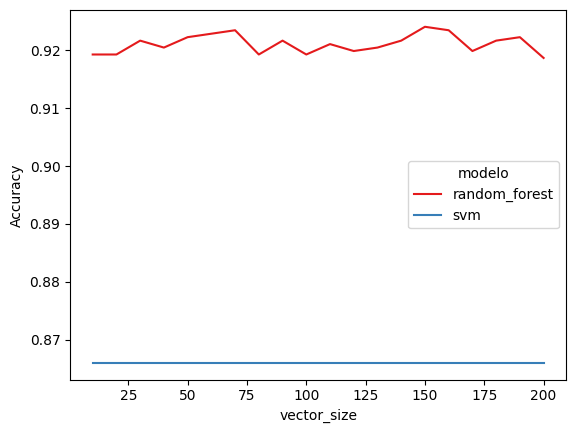

In [84]:
# 5. Graficamos
sns.lineplot(data = vector_size_rta, x="vector_size", y="Accuracy", hue = "modelo", palette="Set1")


<Axes: xlabel='vector_size', ylabel='AUC'>

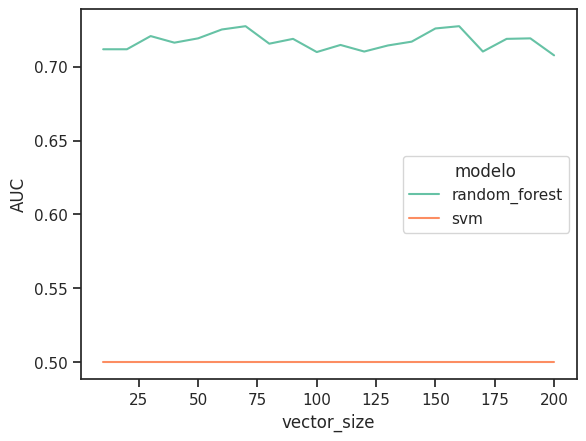

In [98]:
sns.lineplot(data = vector_size_rta, x="vector_size", y="AUC", hue = "modelo", palette="Set2")

parameter variation: `window`

In [99]:
# 6. Variación del parámetro window

window_rta = pd.DataFrame(columns = ['modelo', 'window', 'Accuracy', 'AUC'])
modelo_rf = RandomForestClassifier()
svc = SVC()


In [100]:
# 7. Creamos array de parámetros para iterar el parámetro window

j=0

for modelo_final in ['modelo_rf', 'svc']:
  print(modelo_final)
  for i in range (2,15):
    print (i)

    model2_w2v_1 = gensim.models.Word2Vec(X_Train, vector_size=100, window=i, negative=20, min_count=1, workers=4)

    words = set(model2_w2v_1.wv.index_to_key)
    X_Train_array = np.array([np.array([model2_w2v_1.wv[i] for i in ls if i in words])
                            for ls in X_train])
    X_Test_array = np.array([np.array([model2_w2v_1.wv[i] for i in ls if i in words])
                            for ls in X_test])

    X_train_avg = []
    for v in X_Train_array:
            X_train_avg.append(v.mean(axis=0))

    X_test_avg = []
    for v in X_Test_array:
            X_test_avg.append(v.mean(axis=0))

    if modelo_final == 'modelo_rf':
      modelo_rf = RandomForestClassifier()
      modelo_rf.fit(X_train, y_train)
      y_pred3 = modelo_rf.predict(X_test)
      fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

      window_rta.at[j, 'modelo'] = 'random_forest'
      window_rta.at[j, 'window'] = i
      window_rta.at[j, 'Accuracy'] = accuracy_score(y_test, y_pred3)
      window_rta.at[j, 'AUC'] = auc(fpr, tpr)

      j = j+1

    if modelo_final == 'svc':
      modelo_rf = SVC()
      modelo_rf.fit(X_train, y_train)
      y_pred3 = modelo_rf.predict(X_test)
      fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

      window_rta.at[j, 'modelo'] = 'svm'
      window_rta.at[j, 'window'] = i
      window_rta.at[j, 'Accuracy'] = accuracy_score(y_test, y_pred3)
      window_rta.at[j, 'AUC'] = auc(fpr, tpr)

      j = j+1

modelo_rf
2


3


4


5


6


7


8


9


10


11


12


13


14


svc
2


3


4


5


6


7


8


9


10


11


12


13


14


In [103]:
#Visualizamos los resultados de los modelos
window_rta.head(30)

,modelo,window,Accuracy,AUC
0,random_forest,2,0.924043,0.727839
1,random_forest,3,0.919258,0.711869
2,random_forest,4,0.91866,0.709636
3,random_forest,5,0.919856,0.714101
4,random_forest,6,0.920455,0.714446
5,random_forest,7,0.919258,0.711869
6,random_forest,8,0.921053,0.714791
7,random_forest,9,0.923445,0.721833
8,random_forest,10,0.924043,0.725952
9,random_forest,11,0.922847,0.721488


<Axes: xlabel='window', ylabel='Accuracy'>

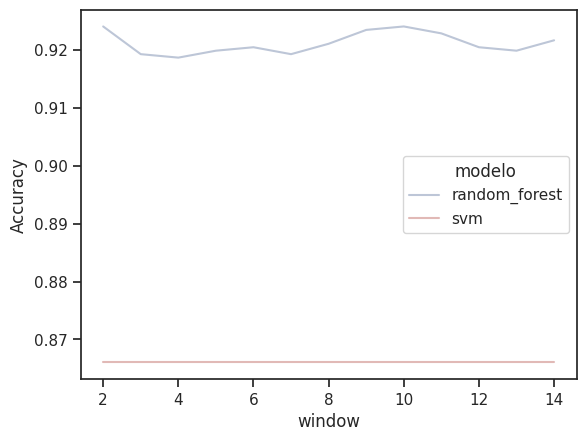

In [104]:
# 8. Graficamos los resultados

sns.lineplot(data = window_rta, x="window", y="Accuracy", hue = "modelo", palette="vlag")


<Axes: xlabel='window', ylabel='AUC'>

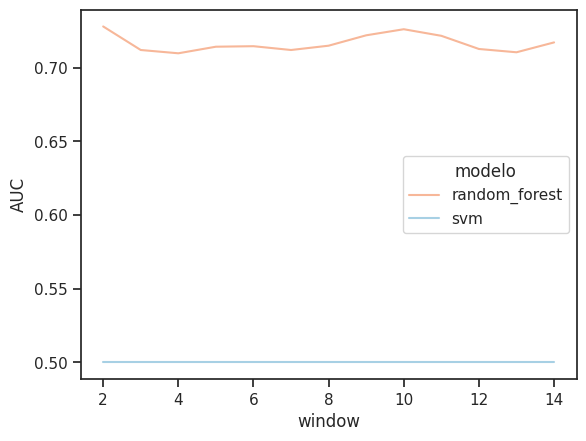

In [105]:
sns.lineplot(data = window_rta, x="window", y="AUC", hue = "modelo", palette="RdBu")

parameter variation: `negative`

In [106]:
# 9.  Variación del parámetro negative

negative_rta = pd.DataFrame(columns = ['modelo', 'negative', 'Accuracy', 'AUC'])
modelo_rf = RandomForestClassifier()
svc = SVC()

In [107]:
#10. Creamos array de parámetros para iterar el parámetro negative

j=0

for modelo_final in ['modelo_rf', 'svc']:
  print(modelo_final)
  for i in range (10,100,10):
    print (i)

    model2_w2v_2 = gensim.models.Word2Vec(X_Train, vector_size=100, window=8, negative=i, min_count=1, workers=4)

    words = set(model2_w2v_2.wv.index_to_key)
    X_Train_array = np.array([np.array([model2_w2v_2.wv[i] for i in ls if i in words])
                            for ls in X_train])
    X_Test_array = np.array([np.array([model2_w2v_2.wv[i] for i in ls if i in words])
                            for ls in X_test])

    X_train_avg = []
    for v in X_Train_array:
            X_train_avg.append(v.mean(axis=0))

    X_test_avg = []
    for v in X_Test_array:
            X_test_avg.append(v.mean(axis=0))

    if modelo_final == 'modelo_rf':
      modelo_rf = RandomForestClassifier()
      modelo_rf.fit(X_train, y_train)
      y_pred4 = modelo_rf.predict(X_test)
      fpr, tpr, thresholds = roc_curve(y_test, y_pred4)

      negative_rta.at[j, 'modelo'] = 'random_forest'
      negative_rta.at[j, 'negative'] = i
      negative_rta.at[j, 'Accuracy'] = accuracy_score(y_test, y_pred4)
      negative_rta.at[j, 'AUC'] = auc(fpr, tpr)

      j = j+1

    if modelo_final == 'svc':
      modelo_rf = SVC()
      modelo_rf.fit(X_train, y_train)
      y_pred4 = modelo_rf.predict(X_test)
      fpr, tpr, thresholds = roc_curve(y_test, y_pred4)

      negative_rta.at[j, 'modelo'] = 'svm'
      negative_rta.at[j, 'negative'] = i
      negative_rta.at[j, 'Accuracy'] = accuracy_score(y_test, y_pred4)
      negative_rta.at[j, 'AUC'] = auc(fpr, tpr)

      j = j+1

modelo_rf
10


20


30


40


50


60


70


80


90


svc
10


20


30


40


50


60


70


80


90


In [108]:
# 11. Visualizamos resultados
negative_rta.head(20)

,modelo,negative,Accuracy,AUC
0,random_forest,10,0.922249,0.719256
1,random_forest,20,0.920455,0.716333
2,random_forest,30,0.923445,0.725607
3,random_forest,40,0.919856,0.712214
4,random_forest,50,0.919258,0.713755
5,random_forest,60,0.919258,0.711869
6,random_forest,70,0.923445,0.725607
7,random_forest,80,0.922249,0.717369
8,random_forest,90,0.922847,0.723375
9,svm,10,0.866029,0.5


<Axes: xlabel='negative', ylabel='Accuracy'>

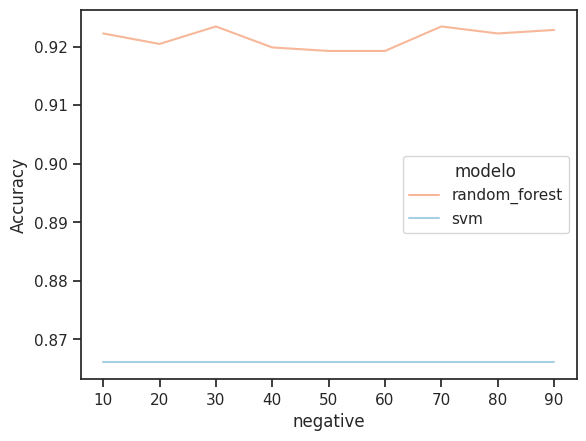

In [109]:
# 12. Graficamos
sns.lineplot(data = negative_rta, x="negative", y="Accuracy", hue = "modelo", palette="RdBu")

<Axes: xlabel='negative', ylabel='AUC'>

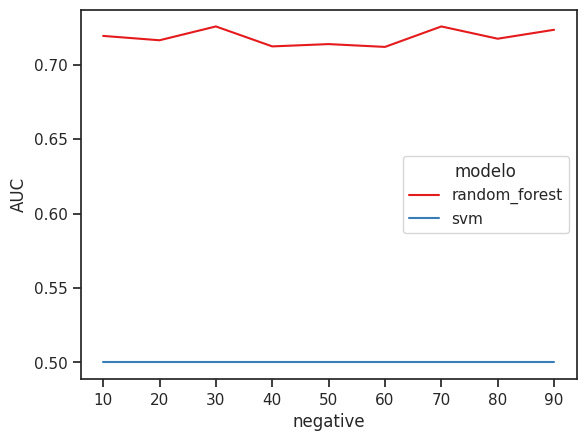

In [110]:
sns.lineplot(data = negative_rta, x="negative", y="AUC", hue = "modelo", palette="Set1")

Running best parameters `vector_size, window and negative` (All at the same time)

In [115]:
# 13. Variación de todos los parámetros al tiempo

todos_rta = pd.DataFrame(columns = ['modelo', 'negative', 'vector_size', 'window', 'Accuracy', 'AUC'])
modelo_rf = RandomForestClassifier()
svc = SVC()
abc = AdaBoostClassifier(n_estimators = 50, random_state = 2)

In [130]:
# 14. Creamos array de parámetros a iterar

j=0

for modelo_final in ['modelo_rf', 'svc', 'abc']:
  print(modelo_final)
  for i in range (40,200,40):
    for k in range (2,6,2):
      for t in range (40,200,40):
        print (i)
        print (k)
        print (t)

        model2_w2v_3 = gensim.models.Word2Vec(X_Train, vector_size=t, window=k, negative=i, min_count=1, workers=4)

        words = set(model2_w2v_3.wv.index_to_key)
        X_Train_array = np.array([np.array([model2_w2v_3.wv[i] for i in ls if i in words])
                            for ls in X_train])
        X_Test_array = np.array([np.array([model2_w2v_3.wv[i] for i in ls if i in words])
                            for ls in X_test])

        X_train_avg = []
        for v in X_Train_array:
            X_train_avg.append(v.mean(axis=0))

        X_test_avg = []
        for v in X_Test_array:
            X_test_avg.append(v.mean(axis=0))

        if modelo_final == 'modelo_rf':
          modelo_rf = RandomForestClassifier()
          modelo_rf.fit(X_train, y_train)
          y_pred5 = modelo_rf.predict(X_test)
          fpr, tpr, thresholds = roc_curve(y_test, y_pred5)

          todos_rta.at[j, 'modelo'] = 'random_forest'
          todos_rta.at[j, 'negative'] = i
          todos_rta.at[j, 'vector_size'] = t
          todos_rta.at[j, 'window'] = k
          todos_rta.at[j, 'Accuracy'] = accuracy_score(y_test, y_pred4)
          todos_rta.at[j, 'AUC'] = auc(fpr, tpr)

          j = j+1

        if modelo_final == 'svc':
          modelo_rf = SVC()
          modelo_rf.fit(X_train, y_train)
          y_pred5 = modelo_rf.predict(X_test)
          fpr, tpr, thresholds = roc_curve(y_test, y_pred5)

          todos_rta.at[j, 'modelo'] = 'svm'
          todos_rta.at[j, 'negative'] = i
          todos_rta.at[j, 'vector_size'] = t
          todos_rta.at[j, 'window'] = k
          todos_rta.at[j, 'Accuracy'] = accuracy_score(y_test, y_pred5)
          todos_rta.at[j, 'AUC'] = auc(fpr, tpr)

          j = j+1

        if modelo_final == 'abc':
          modelo_rf = AdaBoostClassifier(n_estimators = 50, random_state = 2)
          modelo_rf.fit(X_train, y_train)
          y_pred5 = modelo_rf.predict(X_test)
          fpr, tpr, thresholds = roc_curve(y_test, y_pred5)

          todos_rta.at[j, 'modelo'] = 'abc'
          todos_rta.at[j, 'negative'] = i
          todos_rta.at[j, 'vector_size'] = t
          todos_rta.at[j, 'window'] = k
          todos_rta.at[j, 'Accuracy'] = accuracy_score(y_test, y_pred5)
          todos_rta.at[j, 'AUC'] = auc(fpr, tpr)

          j = j+1

modelo_rf
40
2
40


40
2
80


40
2
120


40
2
160


40
4
40


40
4
80


40
4
120


40
4
160


80
2
40


80
2
80


80
2
120


80
2
160


80
4
40


80
4
80


80
4
120


80
4
160


120
2
40


120
2
80


120
2
120


120
2
160


120
4
40


120
4
80


120
4
120


120
4
160


160
2
40


160
2
80


160
2
120


160
2
160


160
4
40


160
4
80


160
4
120


160
4
160


svc
40
2
40


40
2
80


40
2
120


40
2
160


40
4
40


40
4
80


40
4
120


40
4
160


80
2
40


80
2
80


80
2
120


80
2
160


80
4
40


80
4
80


80
4
120


80
4
160


120
2
40


120
2
80


120
2
120


120
2
160


120
4
40


120
4
80


120
4
120


120
4
160


160
2
40


160
2
80


160
2
120


160
2
160


160
4
40


160
4
80


160
4
120


160
4
160


abc
40
2
40


40
2
80


40
2
120


40
2
160


40
4
40


40
4
80


40
4
120


40
4
160


80
2
40


80
2
80


80
2
120


80
2
160


80
4
40


80
4
80


80
4
120


80
4
160


120
2
40


120
2
80


120
2
120


120
2
160


120
4
40


120
4
80


120
4
120


120
4
160


160
2
40


160
2
80


160
2
120


160
2
160


160
4
40


160
4
80


160
4
120


160
4
160


In [131]:
# 15. Visualizamos resultados
todos_rta.head(90)

,modelo,negative,vector_size,window,Accuracy,AUC
0,random_forest,40,40,2,0.866029,0.705863
1,random_forest,40,80,2,0.866029,0.70775
2,random_forest,40,120,2,0.866029,0.716678
3,random_forest,40,160,2,0.866029,0.721142
4,random_forest,40,40,4,0.866029,0.70775
...,...,...,...,...,...,...
85,abc,120,80,4,0.894139,0.689818
86,abc,120,120,4,0.894139,0.689818
87,abc,120,160,4,0.894139,0.689818
88,abc,160,40,2,0.894139,0.689818


<Axes: xlabel='negative', ylabel='AUC'>

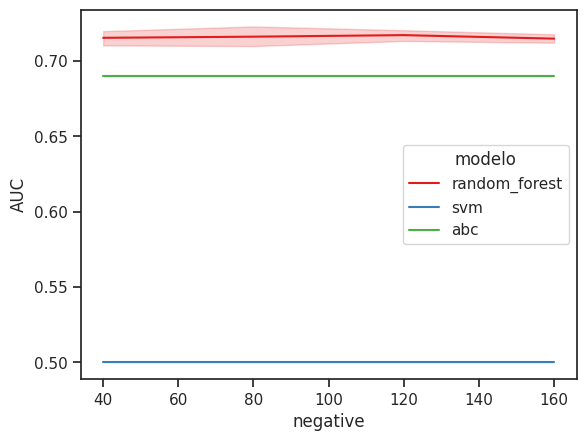

In [132]:
# 12. Graficamos
sns.lineplot(data = todos_rta, x="negative", y="AUC", hue = "modelo", palette="Set1")

Se observa que el modelo AdaBoostClassifier tiene un mejor desempeño con un accuracy de 0.89 aunque un AUC menor con 0.68.